# Denoising Autoencoder

Sticking with the MNIST dataset, let's add noise to our data and see if we can define and train an autoencoder to _de_-noise the images.

<img src='notebook_ims/autoencoder_denoise.png' width=70%/>

Let's get started by importing our libraries and getting the dataset.der.**

In [1]:
!pip install -r requirements.txt | grep -v "already"

In [2]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) # Restart automatically

{'status': 'ok', 'restart': True}

In [6]:
import torch
from torch import nn

import torchvision.models
import torchvision.transforms as T
from torchvision import datasets

import numpy as np
import pandas as pd
import multiprocessing
from tqdm import tqdm

from helpers import (get_data_loaders, seed_all, anomaly_detection_display)

seed_all(42)

In [7]:
data_loaders = get_data_loaders(batch_size=20)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the data

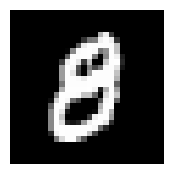

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy()

img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize=(2, 2))
sub.imshow(img, cmap='gray')
_ = sub.axis('off')

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

---
# Denoisinge, autoencoders like the nwe've buiin the other notebook lt so far aren't too useful in practice. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1.

>**We'll use noisy images as input and the original, clean images as targets.** 

Below is an example of some of the noisy images I generated and the associated, denoised im<img src='notebook_ims/denoising.png' />

### Architecture

In [35]:
class ConvDenoiser(nn.Module):

    def __init__(self):
        super(ConvDenoiser, self).__init__()

        ## Encoder ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2), # 32 x 14 x 14
            
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2), # 16 x 7 x 7
            
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2), # 8 x 3 x 3
        )

        # first layer has to have kernel size 3 because 
        # 3x3 using k=2 and s=2 will result in doubling the spatial dim
        # however we need more than doubling since going from 3x3 to 7x7
        # requires increase in kernel size even if we have to produce checkerboard artifacts
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2), # stride 2 doubles the spatial dimension (width & height)
            nn.ReLU(),
            nn.BatchNorm2d(8), # 8 x 7 x 7
            
            nn.ConvTranspose2d(8, 16, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16), # 16 x 14 x 14
            
            nn.ConvTranspose2d(16, 32, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32), # 32 x 28 x 28
            
            nn.Conv2d(32, 1, 3, padding=1), # 1 x 28 x 28
            nn.Sigmoid()
        ) # 1 x 28 x 28

        self.model = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feed-forward behaviour

        return self.model(x)

model = ConvDenoiser()
model.to(device)

ConvDenoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=Tru

In [36]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 32, 28, 28]             320
              ReLU-3           [-1, 32, 28, 28]               0
              ReLU-4           [-1, 32, 28, 28]               0
       BatchNorm2d-5           [-1, 32, 28, 28]              64
       BatchNorm2d-6           [-1, 32, 28, 28]              64
         MaxPool2d-7           [-1, 32, 14, 14]               0
         MaxPool2d-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           4,624
           Conv2d-10           [-1, 16, 14, 14]           4,624
             ReLU-11           [-1, 16, 14, 14]               0
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
      BatchNorm2d-14           [-1, 16,



>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

First let's specify the loss and the optimizer:

---
### Loss Function
We will use se the Mean Squared Error loss, which is called `MSELoss` in PyTorch:

In [37]:
criterion = nn.MSELoss()

### Optimizer

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training

The training loop is similar to a normal training loop, however, this task is an unsupervised task. That means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

In [39]:
n_epochs = 20

# noise factor added to images
noise_factor = 0.5

for epoch in range(1, n_epochs + 1):
    

    ###################
    # train the model #
    ###################
    model.train()

    train_loss = 0.0

    for data in tqdm(
        iterable=data_loaders["train"],
        desc="Training",
        total=len(data_loaders["train"]),
        ncols=80,
    ):
        # Disregard labels
        images, _ = data
        images = images.to(device)

        ## add random noise to the input images
        ## rand_like: Returns a tensor with the same size as :attr:`input` that is filled with
        ## random numbers from a uniform distribution on the interval :math:`[0, 1)`.
        # noisy_imgs = images + noise_factor * torch.randn_like(images)
        noisy_imgs = images + noise_factor * torch.randn(images.shape, device=device)
        
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, min=0., max=1.)
        
        # Clear the gradients of all optimizer variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)

        # calculate the loss
        # the "target" is still the original, not-noisy images
        # because we want the model to learn to learn from the error
        # between the decoded noisy image and the target original image
        # to make the denoising result in an image closer to the original
        loss = criterion(outputs, images)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # validation
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(
            iterable=data_loaders["val"],
            desc="Validating",
            total=len(data_loaders["val"]),
            ncols=80,
        ):
            # Disregard labels
            images, _ = data
            images = images.to(device)

            ## add random noise to the input images
            ## rand_like: Returns a tensor with the same size as :attr:`input` that is filled with
            ## random numbers from a uniform distribution on the interval :math:`[0, 1)`.
            # noisy_imgs = images + noise_factor * torch.rand_like(images)
            noisy_imgs = images + noise_factor * torch.randn(images.shape, device=device)

            # Clip the images to be between 0 and 1
            noisy_imgs = torch.clamp(noisy_imgs, min=0., max=1.)
            
            # Forward pass
            outputs = model(noisy_imgs)

            # Calculate the loss (between input and output)
            loss = criterion(outputs, images)

            val_loss += loss.item() * images.size(0)

    # Print avg training statistics
    train_loss /= len(data_loaders["train"])
    val_loss /= len(data_loaders["val"])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 44.27it/s]


Epoch: 1 	Training Loss: 0.720957	Valid Loss: 0.538131


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 43.87it/s]


Epoch: 2 	Training Loss: 0.489393	Valid Loss: 0.460390


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 43.58it/s]


Epoch: 3 	Training Loss: 0.436315	Valid Loss: 0.420219


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 44.63it/s]


Epoch: 4 	Training Loss: 0.399816	Valid Loss: 0.382209


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 44.38it/s]


Epoch: 5 	Training Loss: 0.375117	Valid Loss: 0.362830


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 43.81it/s]


Epoch: 6 	Training Loss: 0.359411	Valid Loss: 0.350992


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 43.97it/s]


Epoch: 7 	Training Loss: 0.348655	Valid Loss: 0.340430


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 43.71it/s]


Epoch: 8 	Training Loss: 0.341076	Valid Loss: 0.344282


Validating: 100%|█████████████████████████████| 600/600 [00:12<00:00, 49.82it/s]


Epoch: 9 	Training Loss: 0.337300	Valid Loss: 0.335934


Validating: 100%|█████████████████████████████| 600/600 [00:12<00:00, 49.94it/s]


Epoch: 10 	Training Loss: 0.333266	Valid Loss: 0.333180


Validating: 100%|█████████████████████████████| 600/600 [00:11<00:00, 50.03it/s]


Epoch: 11 	Training Loss: 0.330374	Valid Loss: 0.329390


Validating: 100%|█████████████████████████████| 600/600 [00:11<00:00, 50.14it/s]


Epoch: 12 	Training Loss: 0.327639	Valid Loss: 0.322823


Validating: 100%|█████████████████████████████| 600/600 [00:11<00:00, 50.30it/s]


Epoch: 13 	Training Loss: 0.325851	Valid Loss: 0.322486


Validating: 100%|█████████████████████████████| 600/600 [00:12<00:00, 49.74it/s]


Epoch: 14 	Training Loss: 0.324450	Valid Loss: 0.328794


Validating: 100%|█████████████████████████████| 600/600 [00:12<00:00, 48.74it/s]


Epoch: 15 	Training Loss: 0.322543	Valid Loss: 0.319141


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 43.67it/s]


Epoch: 16 	Training Loss: 0.321174	Valid Loss: 0.319314


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 43.66it/s]


Epoch: 17 	Training Loss: 0.320096	Valid Loss: 0.320254


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 44.15it/s]


Epoch: 18 	Training Loss: 0.318393	Valid Loss: 0.316464


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 44.31it/s]


Epoch: 19 	Training Loss: 0.316920	Valid Loss: 0.318407


Validating: 100%|█████████████████████████████| 600/600 [00:13<00:00, 43.35it/s]

Epoch: 20 	Training Loss: 0.316817	Valid Loss: 0.327780


### Save the model

In [40]:
# Save the weights to save_path
torch.save(model.state_dict(), "conv_denoiser.pt")

## Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.look:

In [14]:
# load the model
model.load_state_dict(torch.load('conv_denoiser.pt'))
model.eval()

ConvDenoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=Tru

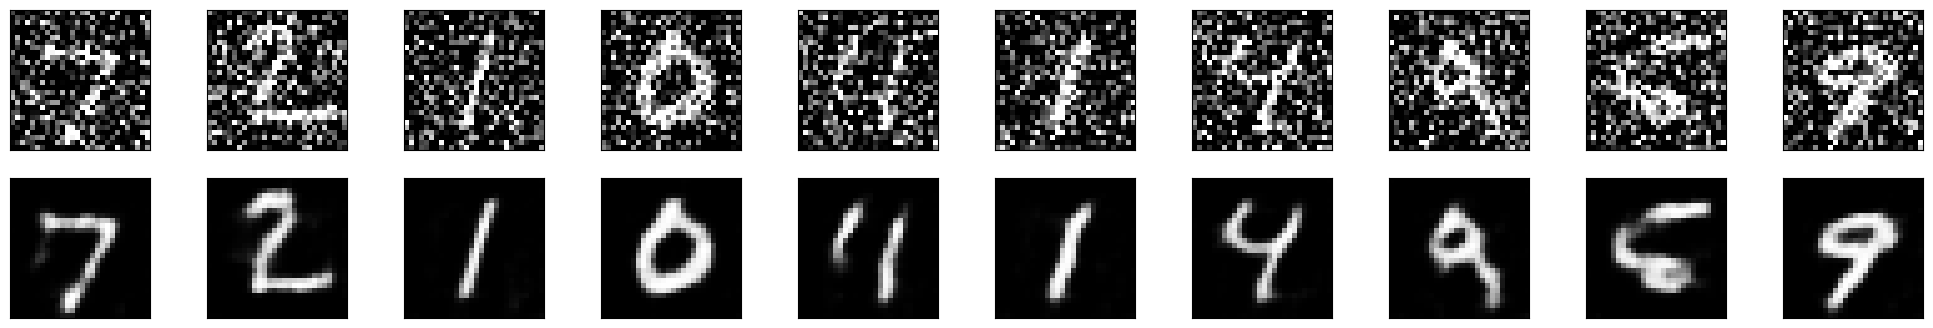

In [41]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])
images, labels = next(dataiter)

# add noise to the test images (model input)
noisy_imgs = images + 0.5 * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample output
outputs = model(noisy_imgs.cuda())
# prep imgs for display
noisy_imgs = noisy_imgs.numpy()

# print(outputs.requires_grad)
# output is resized into batch of images
outputs = outputs.view(20, 1, 28, 28)
# use detach when its output that requires_grad
outputs = outputs.detach().cpu().numpy()

# plot first ten input images and then reconstructed images
fig, axes = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(25, 4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, outputs], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)